In [ ]:
! pip install scanpy python-igraph louvain leidenalg pybiomart annoy

## Get data
- 6 PBMC 10x datasets

- 3 Covid19-patients and 3 healthy controls

- subsampled to 1500 cells/sample

In [2]:
%%bash
# create a data directory.
mkdir -p data/raw

# first check if the files are there
count=$(ls -l data/raw/*.h5 | grep -v ^d | wc -l )
echo $count

# if not 4 files, fetch the files from github.
if (("$count" <  6)); then
  cd data/raw
  curl -O https://raw.githubusercontent.com/NBISweden/workshop-scRNAseq/new_dataset/labs/data/covid_data_GSE149689/sub/Normal_PBMC_13.h5
  curl -O https://raw.githubusercontent.com/NBISweden/workshop-scRNAseq/new_dataset/labs/data/covid_data_GSE149689/sub/Normal_PBMC_14.h5
  curl -O https://raw.githubusercontent.com/NBISweden/workshop-scRNAseq/new_dataset/labs/data/covid_data_GSE149689/sub/Normal_PBMC_5.h5
  curl -O https://raw.githubusercontent.com/NBISweden/workshop-scRNAseq/new_dataset/labs/data/covid_data_GSE149689/sub/nCoV_PBMC_15.h5
  curl -O https://raw.githubusercontent.com/NBISweden/workshop-scRNAseq/new_dataset/labs/data/covid_data_GSE149689/sub/nCoV_PBMC_17.h5
  curl -O https://raw.githubusercontent.com/NBISweden/workshop-scRNAseq/new_dataset/labs/data/covid_data_GSE149689/sub/nCoV_PBMC_1.h5
  cd ../..
fi

ls -lGa data/raw

0
total 22196
drwxr-xr-x 2 root    4096 Aug 24 06:38 .
drwxr-xr-x 3 root    4096 Aug 24 06:38 ..
-rw-r--r-- 1 root 3169573 Aug 24 06:38 nCoV_PBMC_15.h5
-rw-r--r-- 1 root 4105636 Aug 24 06:38 nCoV_PBMC_17.h5
-rw-r--r-- 1 root 3426598 Aug 24 06:38 nCoV_PBMC_1.h5
-rw-r--r-- 1 root 4391693 Aug 24 06:38 Normal_PBMC_13.h5
-rw-r--r-- 1 root 3806925 Aug 24 06:38 Normal_PBMC_14.h5
-rw-r--r-- 1 root 3806384 Aug 24 06:38 Normal_PBMC_5.h5


ls: cannot access 'data/raw/*.h5': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4288k  100 4288k    0     0  15.4M      0 --:--:-- --:--:-- --:--:-- 15.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3717k  100 3717k    0     0  20.6M      0 --:--:-- --:--:-- --:--:-- 20.6M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3717k  100 3717k    0     0  19.1M      0 --:--:-- --:--:-- --:--:-- 19.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3095k  100 3095k    0     0  15.9M      0 --:--:-- --:--:-- --:--:

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)

In [2]:
data_cov1 = sc.read_10x_h5('./data/raw/nCoV_PBMC_1.h5')
data_cov1.var_names_make_unique()
data_cov15 = sc.read_10x_h5('./data/raw/nCoV_PBMC_15.h5')
data_cov15.var_names_make_unique()
data_cov17 = sc.read_10x_h5('./data/raw/nCoV_PBMC_17.h5')
data_cov17.var_names_make_unique()
data_ctrl5 = sc.read_10x_h5('./data/raw/Normal_PBMC_5.h5')
data_ctrl5.var_names_make_unique()
data_ctrl13 = sc.read_10x_h5('./data/raw/Normal_PBMC_13.h5')
data_ctrl13.var_names_make_unique()
data_ctrl14 = sc.read_10x_h5('./data/raw/Normal_PBMC_14.h5')
data_ctrl14.var_names_make_unique()

reading ./data/raw/nCoV_PBMC_1.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ./data/raw/nCoV_PBMC_15.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ./data/raw/nCoV_PBMC_17.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ./data/raw/Normal_PBMC_5.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ./data/raw/Normal_PBMC_13.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


reading ./data/raw/Normal_PBMC_14.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:00)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## Create one merged object

In [3]:
# add some metadata
data_cov1.obs['type']="Covid"
data_cov1.obs['sample']="covid_1"
data_cov15.obs['type']="Covid"
data_cov15.obs['sample']="covid_15"
data_cov17.obs['type']="Covid"
data_cov17.obs['sample']="covid_17"
data_ctrl5.obs['type']="Ctrl"
data_ctrl5.obs['sample']="ctrl_5"
data_ctrl13.obs['type']="Ctrl"
data_ctrl13.obs['sample']="ctrl_13"
data_ctrl14.obs['type']="Ctrl"
data_ctrl14.obs['sample']="ctrl_14"


# merge into one object.
adata = data_cov1.concatenate(data_cov15, data_cov17, data_ctrl5, data_ctrl13, data_ctrl14)

# and delete individual datasets to save space
del(data_cov1, data_cov15, data_cov17)
del(data_ctrl5, data_ctrl13, data_ctrl14)

In [4]:
print(adata.obs['sample'].value_counts())
adata

covid_15    1500
covid_1     1500
ctrl_13     1500
covid_17    1500
ctrl_14     1500
ctrl_5      1500
Name: sample, dtype: int64


AnnData object with n_obs × n_vars = 9000 × 33538
    obs: 'type', 'sample', 'batch'
    var: 'gene_ids', 'feature_types', 'genome'

## Calculate QC

Having the data in a suitable format, we can start calculating some quality metrics. We can for example calculate the percentage of mitocondrial and ribosomal genes per cell and add to the metadata. This will be helpfull to visualize them across different metadata parameteres (i.e. datasetID and chemistry version). There are several ways of doing this, and here manually calculate the proportion of mitochondrial reads and add to the metadata table.
Citing from "Simple Single Cell" workflows (Lun, McCarthy & Marioni, 2017): "High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane."

First, let Scanpy calculate some general qc-stats for genes and cells with the function `sc.pp.calculate_qc_metrics`, similar to `calculateQCmetrics` in Scater. It can also calculate proportion of counts for specific gene populations, so first we need to define which genes are mitochondrial, ribosomal and hemoglogin.

In [5]:
# mitochondrial genes
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
# ribosomal genes
adata.var['ribo'] = adata.var_names.str.startswith(("RPS","RPL"))
# hemoglobin genes.
adata.var['hb'] = adata.var_names.str.contains(("^HB[^(P)]"))

adata.var

gene_ids    feature_types  genome     mt   ribo     hb
MIR1302-2HG  ENSG00000243485  Gene Expression  GRCh38  False  False  False
FAM138A      ENSG00000237613  Gene Expression  GRCh38  False  False  False
OR4F5        ENSG00000186092  Gene Expression  GRCh38  False  False  False
AL627309.1   ENSG00000238009  Gene Expression  GRCh38  False  False  False
AL627309.3   ENSG00000239945  Gene Expression  GRCh38  False  False  False
...                      ...              ...     ...    ...    ...    ...
AC233755.2   ENSG00000277856  Gene Expression  GRCh38  False  False  False
AC233755.1   ENSG00000275063  Gene Expression  GRCh38  False  False  False
AC240274.1   ENSG00000271254  Gene Expression  GRCh38  False  False  False
AC213203.1   ENSG00000277475  Gene Expression  GRCh38  False  False  False
FAM231C      ENSG00000268674  Gene Expression  GRCh38  False  False  False

[33538 rows x 6 columns]

In [6]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo', 'hb'], percent_top=None, log1p=False, inplace=True)

In [7]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mt2'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

In [8]:
adata

AnnData object with n_obs × n_vars = 9000 × 33538
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

## Plot QC

... storing 'type' as categorical
... storing 'sample' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


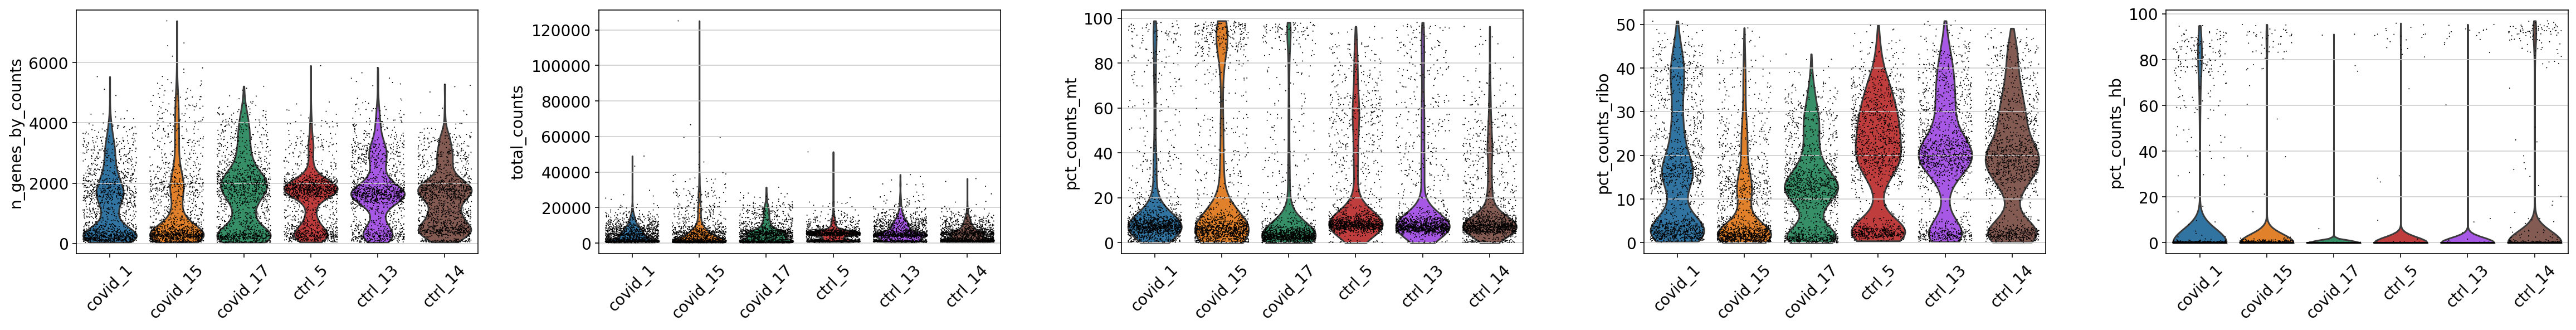

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, groupby='sample', rotation=45)

As you can see, there is quite some difference in quality for the 4 datasets, with for instance the covid_15 sample having fewer cells with many detected genes and more mitochondrial content. As the ribosomal proteins are highly expressed they will make up a larger proportion of the transcriptional landscape when fewer of the lowly expressed genes are detected. And we can plot the different QC-measures as scatter plots.

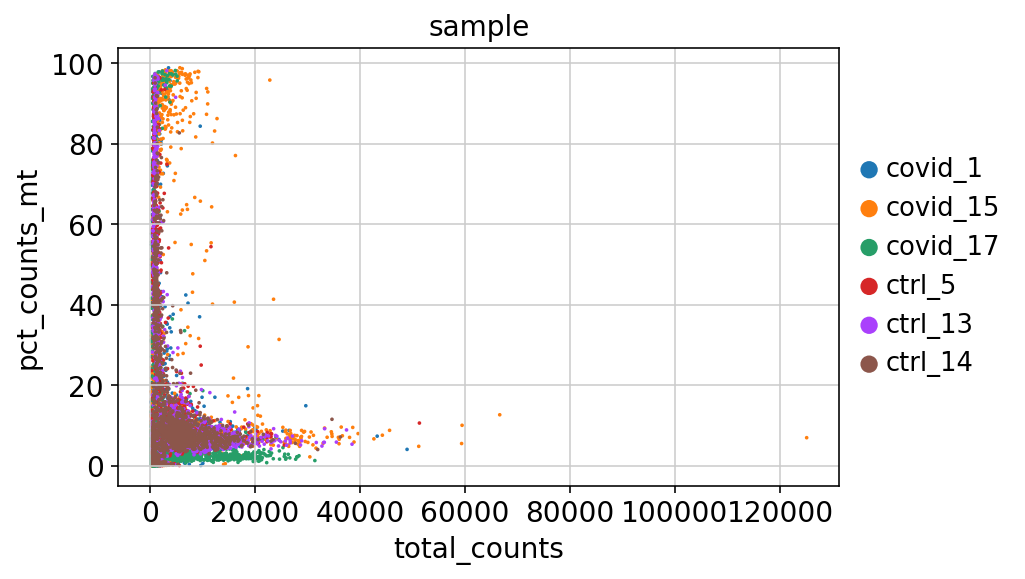

In [10]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color='sample')

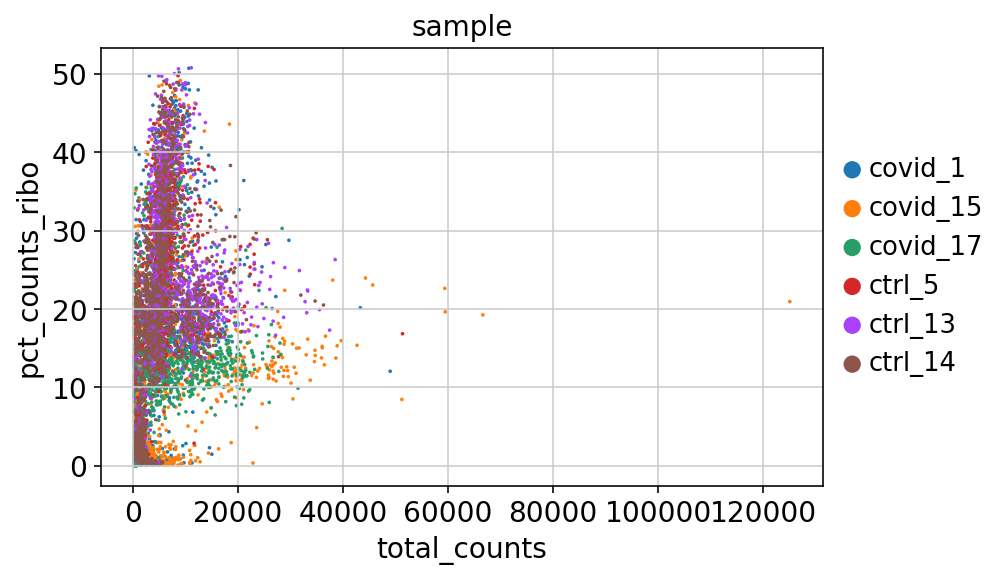

In [11]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_ribo', color='sample')

In [12]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_hb', color='sample')

In [13]:
sc.pl.scatter(adata, x='total_counts', y='percent_mt2', color='sample')

## Filtering

- filtere cells w/ low amount of reads as well as genes that are present in at least a certain amount of cells

In [14]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

print(adata.n_obs, adata.n_vars)

filtered out 1021 cells that have less than 200 genes expressed
filtered out 14760 genes that are detected in less than 3 cells
7979 18778


normalizing counts per cell
    finished (0:00:00)


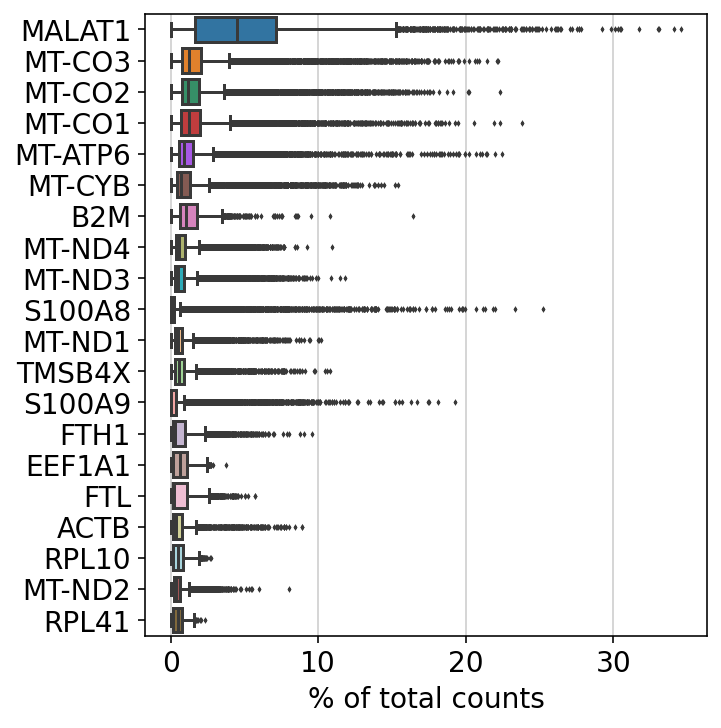

In [15]:
sc.pl.highest_expr_genes(adata, n_top=20)

As you can see, MALAT1 constitutes up to 30% of the UMIs from a single cell and the other top genes are mitochondrial and ribosomal genes. It is quite common that nuclear lincRNAs have correlation with quality and mitochondrial reads, so high detection of MALAT1 may be a technical issue. Let us assemble some information about such genes, which are important for quality control and downstream filtering.

## Mito/Ribo filtering

We also have quite a lot of cells with high proportion of mitochondrial and low proportion of ribosomal reads. It could be wise to remove those cells, if we have enough cells left after filtering. 

Another option would be to either remove all mitochondrial reads from the dataset and hope that the remaining genes still have enough biological signal. 
A third option would be to just regress out the percent_mito variable during scaling. In this case we had as much as 99.7% mitochondrial reads in some of the cells, so it is quite unlikely that there is much cell type signature left in those. 

Looking at the plots, make reasonable decisions on where to draw the cutoff. In this case, the bulk of the cells are below 20% mitochondrial reads and that will be used as a cutoff. We will also remove cells with less than 5% ribosomal reads.

In [16]:
# filter for % mito
adata = adata[adata.obs['pct_counts_mt'] < 20, :]

# filter for percent ribo > 0.05
adata = adata[adata.obs['pct_counts_ribo'] > 5, :]

print('Remaining cells %d'%adata.n_obs)


Remaining cells 5762


## Plot filtered QC


In [17]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo',
                     'pct_counts_hb'],
             jitter=0.4, groupby='sample', rotation=45)

## Filter genes

As the level of expression of mito and MALAT1 genes are judged as mainly technical, it can be wise to remove them from the dataset before any further analysis

In [18]:
malat1 = adata.var_names.str.startswith('MALAT1')

# need to redefine mito genes since they were first calculated on the full object before removing low expressed genes

mito_genes = adata.var_names.str.startswith('MT-')
hb_genes = adata.var_names.str.contains('^HB[^(P)]')

remove = np.add(mito_genes, malat1)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:, keep]

print(adata.n_obs, adata.n_vars)

5762 18752


## Sample sex

When working with human or animal samples, you should ideally constrain you experiments to a single sex to avoid including sex bias in the conclusions. However this may not always be possible. By looking at reads from chromosomeY (males) and XIST (X-inactive specific transcript) expression (mainly female) it is quite easy to determine per sample which sex it is. It can also bee a good way to detect if there has been any sample mixups, if the sample metadata sex does not agree with the computational predictions.

To get choromosome information for all genes, you should ideally parse the information from the gtf file that you used in the mapping pipeline as it has the exact same annotation version/gene naming. However, it may not always be available, as in this case where we have downloaded public data. Hence, we will use biomart to fetch chromosome information.

In [19]:
annot = sc.queries.biomart_annotations(
    'hsapiens',
    ['ensembl_gene_id', 'external_gene_name', 'start_position', 'end_position', 
     'chromosome_name'],
     ).set_index('external_gene_name')

In [20]:
# with chromosome information, we can calculate per cell the proportion of reads that come from chromosome Y
chrY_genes = adata.var_names.intersection(annot.index[annot.chromosome_name == 'Y'])
chrY_genes

Index(['RPS4Y1', 'ZFY', 'ZFY-AS1', 'LINC00278', 'PCDH11Y', 'USP9Y', 'DDX3Y',
       'UTY', 'TMSB4Y', 'NLGN4Y', 'TTTY14', 'KDM5D', 'EIF1AY', 'RPS4Y2'],
      dtype='object')

In [21]:
adata.obs['percent_chrY'] = np.sum(adata[:, chrY_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1 * 100

Trying to set attribute `.obs` of view, copying.


In [22]:
# plot XIST vs chrY proportion
adata.obs['XIST-counts'] = adata.X[:, adata.var_names.str.match('XIST')].toarray()

sc.pl.scatter(adata, x='XIST-counts', y='percent_chrY', color='sample')

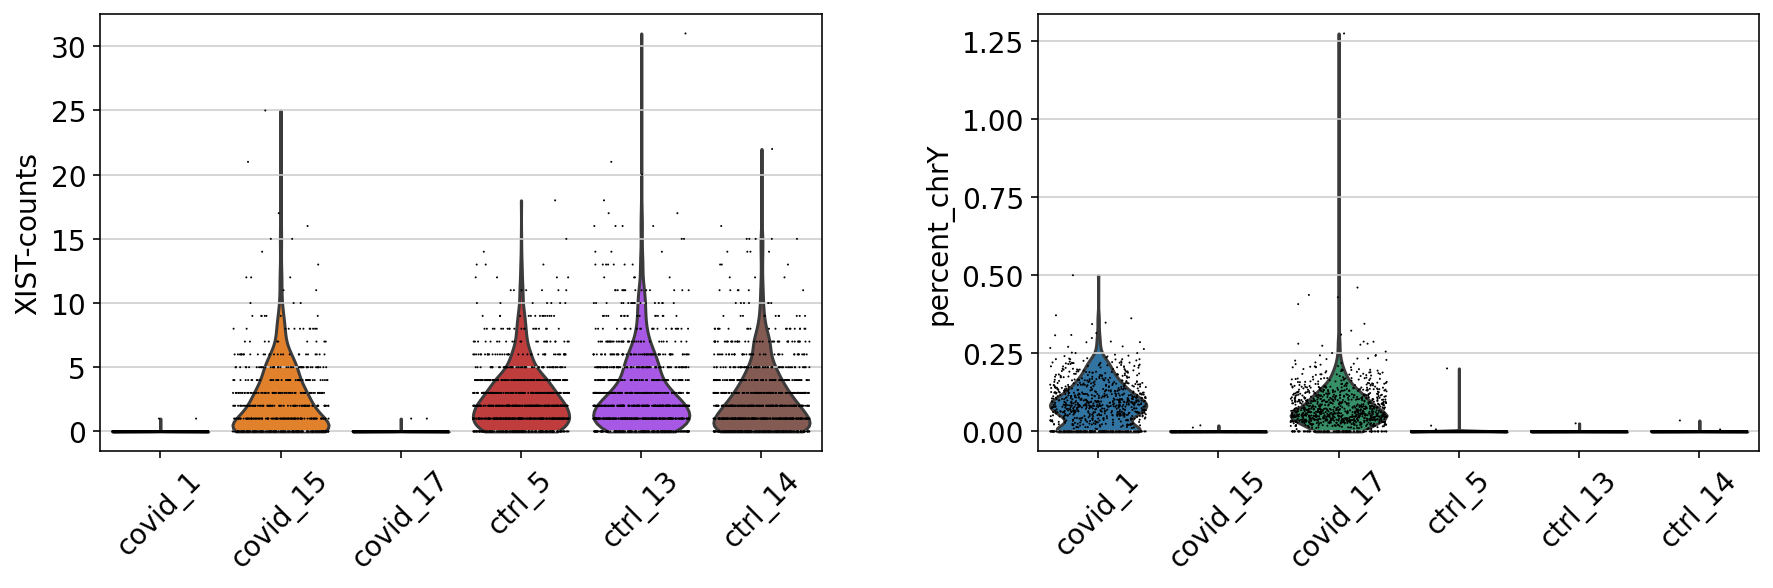

In [23]:
sc.pl.violin(adata, ['XIST-counts', 'percent_chrY'], jitter=0.4, groupby='sample', rotation=45)

Clearly, there are 2 males and 4 females.

Males: covid_1, covid_17

Females: covid_15, ctrl_5, ctrl_13, ctrl_14

What would be the best way to deal with this type of sex bias?

## Calculate cell-cycle scores

We here perform cell cycle scoring. To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list. Cell cycle scoring adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.

First read the file with cell cycle genes, from Regev lab and split into S and G2M phase genes. Cell cycle genes were retrieved from the scanpy_usage github site via web browser at RegevLab Github repo.

In [24]:
!if [ ! -f data/regev_lab_cell_cycle_genes.txt ]; then curl -o data/regev_lab_cell_cycle_genes.txt https://raw.githubusercontent.com/theislab/scanpy_usage/master/180209_cell_cycle/data/regev_lab_cell_cycle_genes.txt; fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   556  100   556    0     0   5560      0 --:--:-- --:--:-- --:--:--  5560


In [25]:
cell_cycle_genes = [x.strip() for x in open('./data/regev_lab_cell_cycle_genes.txt')]
print(len(cell_cycle_genes))

# Split into 2 lists
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]
print(len(cell_cycle_genes))

97
94


In [27]:
# normalize before running cell cycle
adata.raw = adata

# normalize to depth 10000
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

sc.pp.log1p(adata)

sc.pp.scale(adata)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


We here perform cell cycle scoring. The function is actually a wrapper to sc.tl.score_gene_list, which is launched twice, to score separately S and G2M phases. Both sc.tl.score_gene_list and sc.tl.score_cell_cycle_genes are a port from Seurat and are supposed to work in a very similar way. To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list. Cell cycle scoring adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.

In [28]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    815 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    812 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


... storing 'phase' as categorical


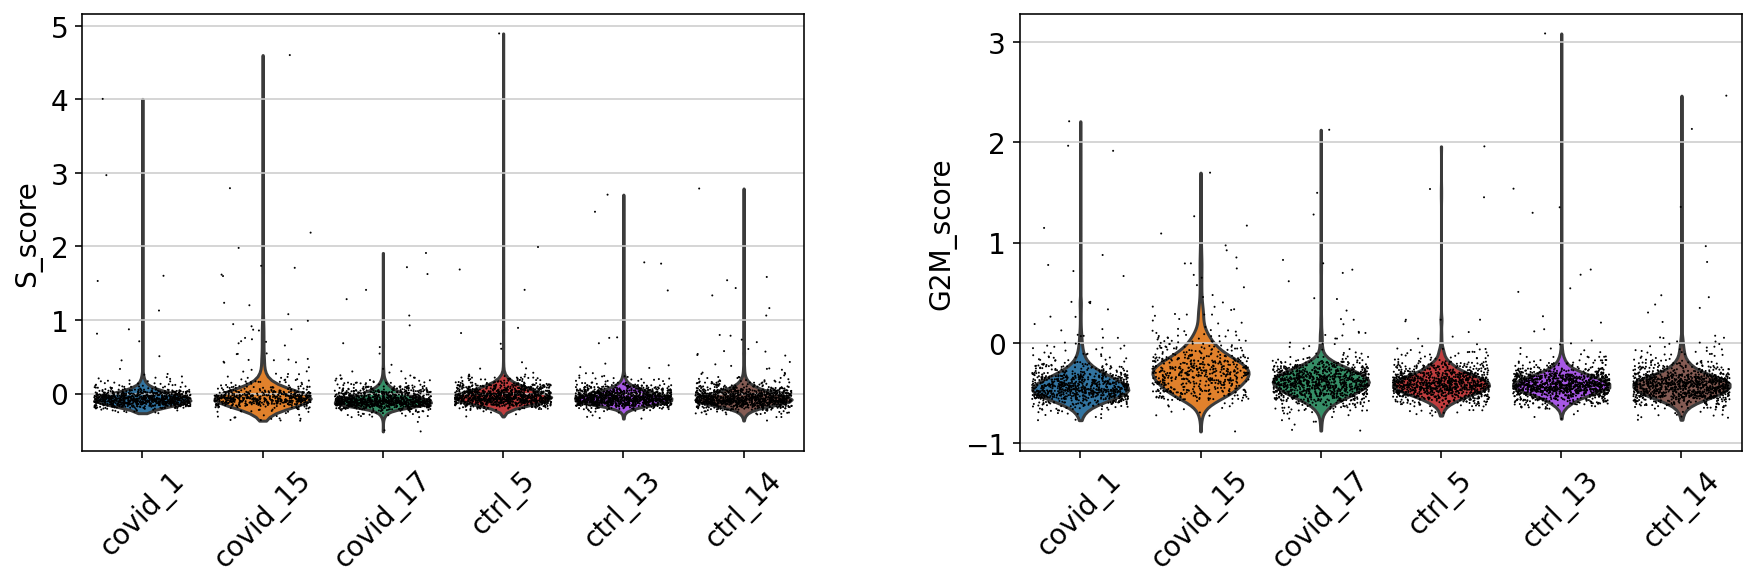

In [29]:
sc.pl.violin(adata, ['S_score', 'G2M_score'],
             jitter=0.4, groupby='sample', rotation=45)

In this case, it looks like we only have a few cycling cells in the datasets


## Predict doublets

In a typical 10x experiment the proportion of doublets is linearly dependent on the amount of loaded cells

Most doublet detectors simulates doublets by merging cell counts and predicts doublets as cells that have similar embeddings as the simulated doublets. Most such packages need an assumption about the number/proportion of expected doublets in the dataset. The data you are using is subsampled, but the orignial datasets contained about 5 000 cells per sample, hence we can assume that they loaded about 9 000 cells and should have a doublet rate at about 4%. OBS! Ideally doublet prediction should be run on each sample separately, especially if your different samples have different proportions of celltypes. In this case, the data is subsampled so we have very few cells per sample and all samples are sorted PBMCs so it is okay to run them together.

For doublet detection, we will use the package Scrublet, so first we need to get the raw counts from adata.raw.X and run scrublet with that matrix. Then we add in the doublet prediction info into our anndata object.

In [30]:
! pip install scrublet

     |████████████████████████████████| 646 kB 37.0 MB/s 
  Created wheel for annoy: filename=annoy-1.17.0-cp37-cp37m-linux_x86_64.whl size=391653 sha256=5f34113f86a360661157fe206578862f6c33bd87929605fd91aa6a2aea8cdedb
  Stored in directory: /root/.cache/pip/wheels/4f/e8/1e/7cc9ebbfa87a3b9f8ba79408d4d31831d67eea918b679a4c07
Successfully built annoy


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.42
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 58.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.1%
Elapsed time: 11.2 seconds


103

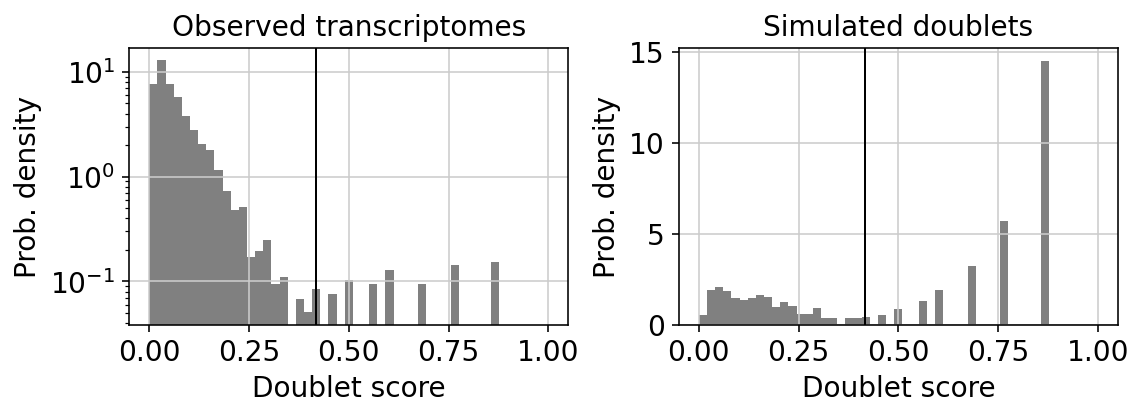

In [31]:
import scrublet as scr
scrub = scr.Scrublet(adata.raw.X)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(adata.obs['predicted_doublets'])

In [32]:
# add in column with singlet/doublet instead of True/false

adata.obs['doublet_info'] = adata.obs['predicted_doublets'].astype(str)

... storing 'doublet_info' as categorical


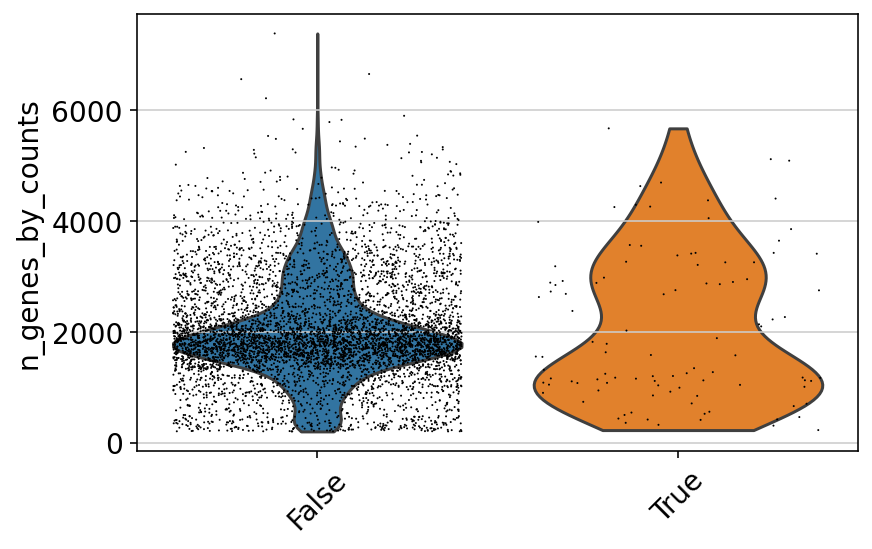

In [33]:
sc.pl.violin(adata, 'n_genes_by_counts',
             jitter=0.4, groupby='doublet_info', rotation=45)

In [34]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)

extracting highly variable genes


/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_utils.py:11: RuntimeWarning: overflow encountered in multiply
  mean_sq = np.multiply(X, X).mean(axis=axis, dtype=np.float64)


    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
regressing out ['total_counts', 'pct_counts_mt']


/usr/local/lib/python3.7/dist-packages/scanpy/preprocessing/_highly_variable_genes.py:240: RuntimeWarning: invalid value encountered in true_divide
  ) / disp_std_bin[df['mean_bin'].values].values
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


    finished (0:00:18)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 40


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:22)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:16)


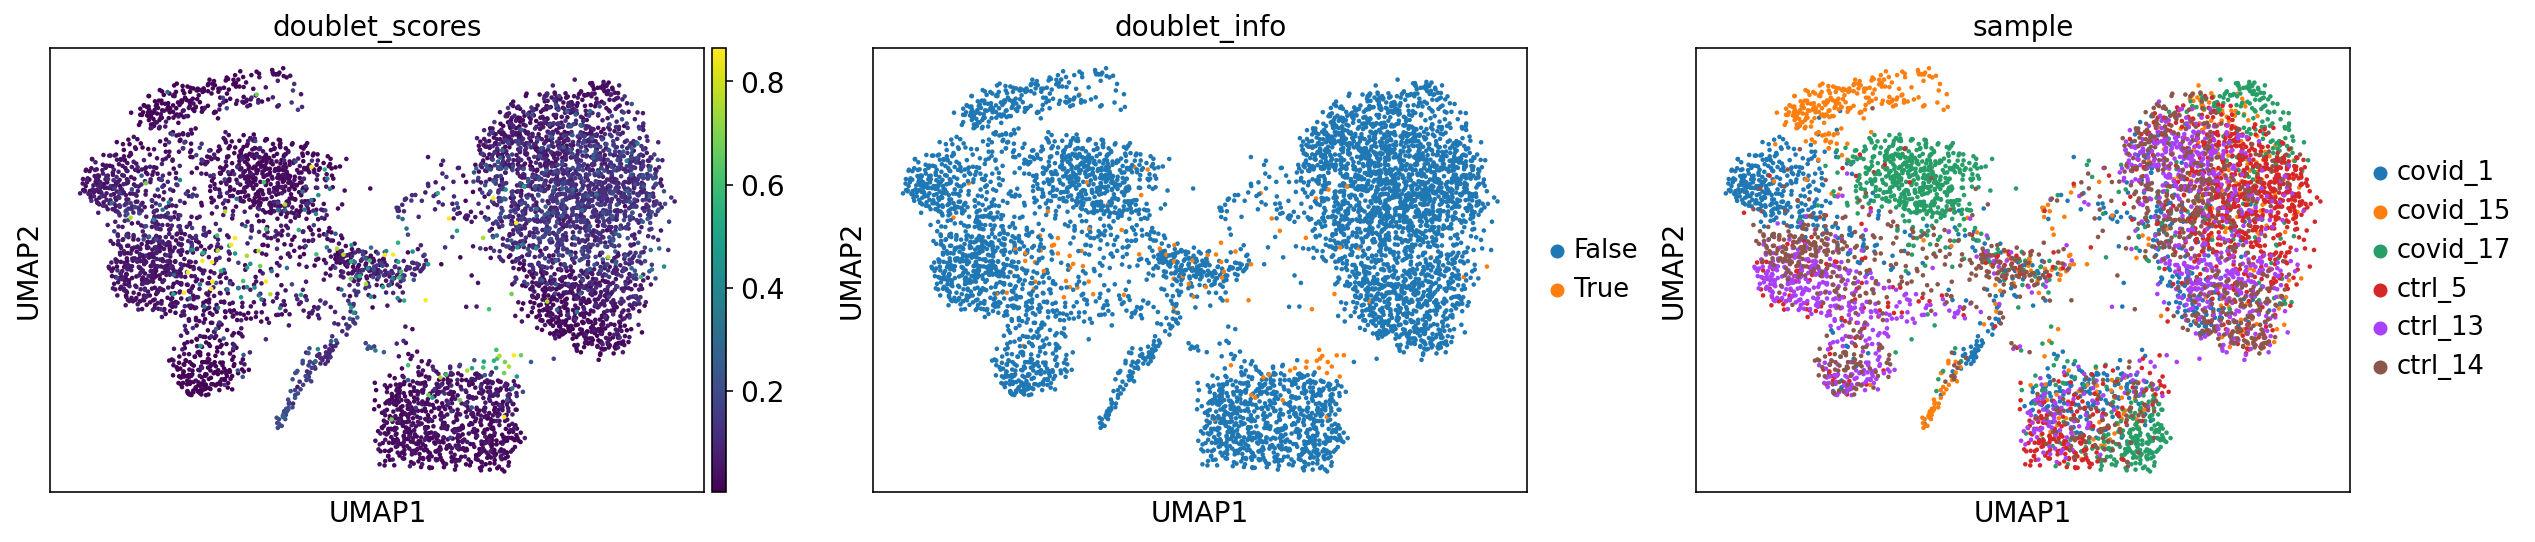

In [35]:
sc.pl.umap(adata, color=['doublet_scores', 'doublet_info', 'sample'])

In [36]:
# also revert back to the raw counts as the main matrix in adata
adata = adata.raw.to_adata() 

adata = adata[adata.obs['doublet_info'] == 'False',:]
print(adata.shape)


(5659, 18752)


In [37]:
import os
os.makedirs('data/results/', exist_ok=True)

save_file = 'data/results/scanpy_qc_filtered_covid.h5ad'
adata.write_h5ad(save_file)